## Time Series Forecasting with Statsmodels and Prophet

In [2]:
# Core data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time series analysis
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.filters.hp_filter import hpfilter

# Machine learning
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Feature engineering
from sklearn.preprocessing import StandardScaler

In [3]:
# set Theme
sns.set_theme(style='whitegrid', palette='pastel')

In [4]:
## Import charge-off and recovery data
core_data = pd.read_csv('co_rec_data.csv',index_col=1,parse_dates=True)
core_data.rename(columns={' CO_BAL ': 'CO_BAL', ' REC_BAL ': 'REC_BAL'}, inplace=True)
core_data = pd.DataFrame(core_data)

## Clean data - drop unnecessary columns, set index to monthend data
core_data.drop(columns='SEQUENCE', inplace=True)
core_data.index.freq = 'Me'

# Set display for all rows and columns on print
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# set numeric value display - remove scientific notation and truncation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Add ratio column
core_data['ratio'] = core_data['REC_BAL']/core_data['CO_BAL']

C:\Users\iantm\AppData\Local\Temp\ipykernel_23436\2171361735.py:8: FutureWarning: 'Me' is deprecated and will be removed in a future version, please use 'ME' instead.
  core_data.index.freq = 'Me'


In [5]:

# 1) EDA Phase of testing the data - DickFuller, correlation, structural breaks?
# 2) Start by Charting our data
# ?? Then add a linear regression line
# 3) Then add a hpfilter to forecast out a general trend
# ?? Run rsme, error bands and what else?
# 4) Run forecast on data, but test it? how close of prediction can it make?
# 5) Build out Lag function and leverage XGBoost - How much closer does it get?
# 6) Conclusion should be leveraging the best portfolio estimates and why?

#### 1 EDA Analysis

##### 1.1 Data Overview and Quality Assessment

In [6]:
# Basic data exploration
print("Dataset Info:")
print(f"Shape: {core_data.shape}")
print(f"Date range: {core_data.index.min()} to {core_data.index.max()}")
print(f"Frequency: {core_data.index.freq}")

# Summary statistics
print("\nSummary Statistics:")
print(core_data.describe())

Dataset Info:
Shape: (78, 3)
Date range: 2019-01-31 00:00:00 to 2025-06-30 00:00:00
Frequency: <MonthEnd>

Summary Statistics:
          CO_BAL   REC_BAL  ratio
count      78.00     78.00  78.00
mean   699395.20 200030.05   0.35
std    330273.55  78735.23   0.18
min    229725.86  81280.66   0.08
25%    398936.93 142716.81   0.20
50%    649210.21 186885.60   0.31
75%    929631.33 239869.05   0.46
max   1430176.65 533885.74   0.82


Comment on the data

##### 1.2 Stationary Testing

In [7]:
def stationarity_test(series, title):
    """Comprehensive stationarity analysis"""
    print(f"\n=== Stationarity Test: {title} ===")
    
    # Acore_data Test
    acore_data_result = acore_datauller(series.dropna())
    print(f"Acore_data Statistic: {acore_data_result[0]:.6f}")
    print(f"p-value: {acore_data_result[1]:.6f}")
    print("Critical Values:")
    for key, value in acore_data_result[4].items():
        print(f"\t{key}: {value:.3f}")
    
    if acore_data_result[1] <= 0.05:
        print("✓ Series is stationary (reject null hypothesis)")
    else:
        print("✗ Series is non-stationary (fail to reject null hypothesis)")
    
    return acore_data_result[1] <= 0.05

# Test both series
charge_off_stationary = stationarity_test(core_data['CO_BAL'], 'Charge-offs')
recovery_stationary = stationarity_test(core_data['REC_BAL'], 'Recoveries')


=== Stationarity Test: Charge-offs ===


NameError: name 'acore_datauller' is not defined

Comment on the output

##### 1.3 Seasonality & Decomposition Analysis

Charge-offs Seasonality Strength: 0.324
Recoveries Seasonality Strength: 0.367


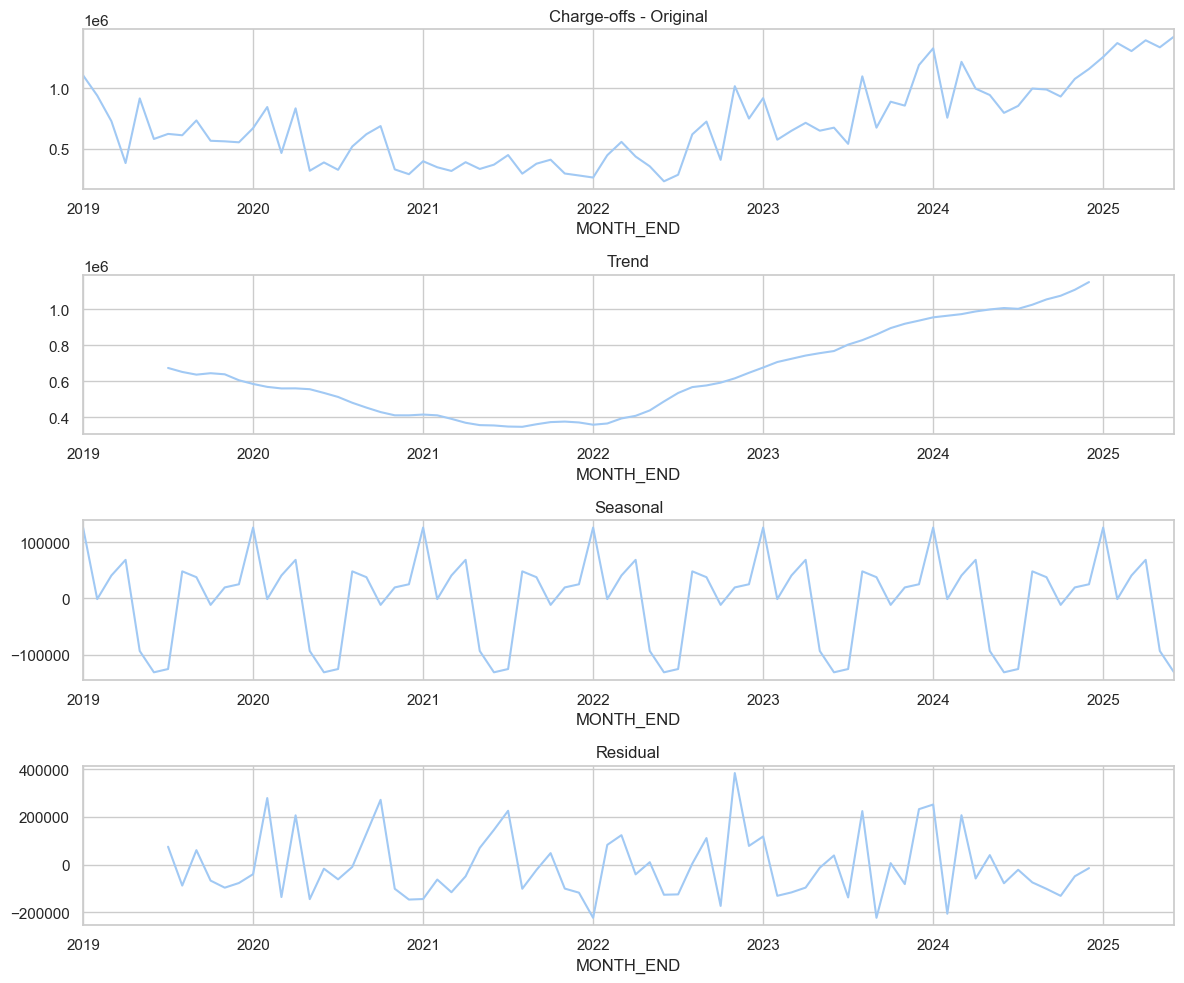

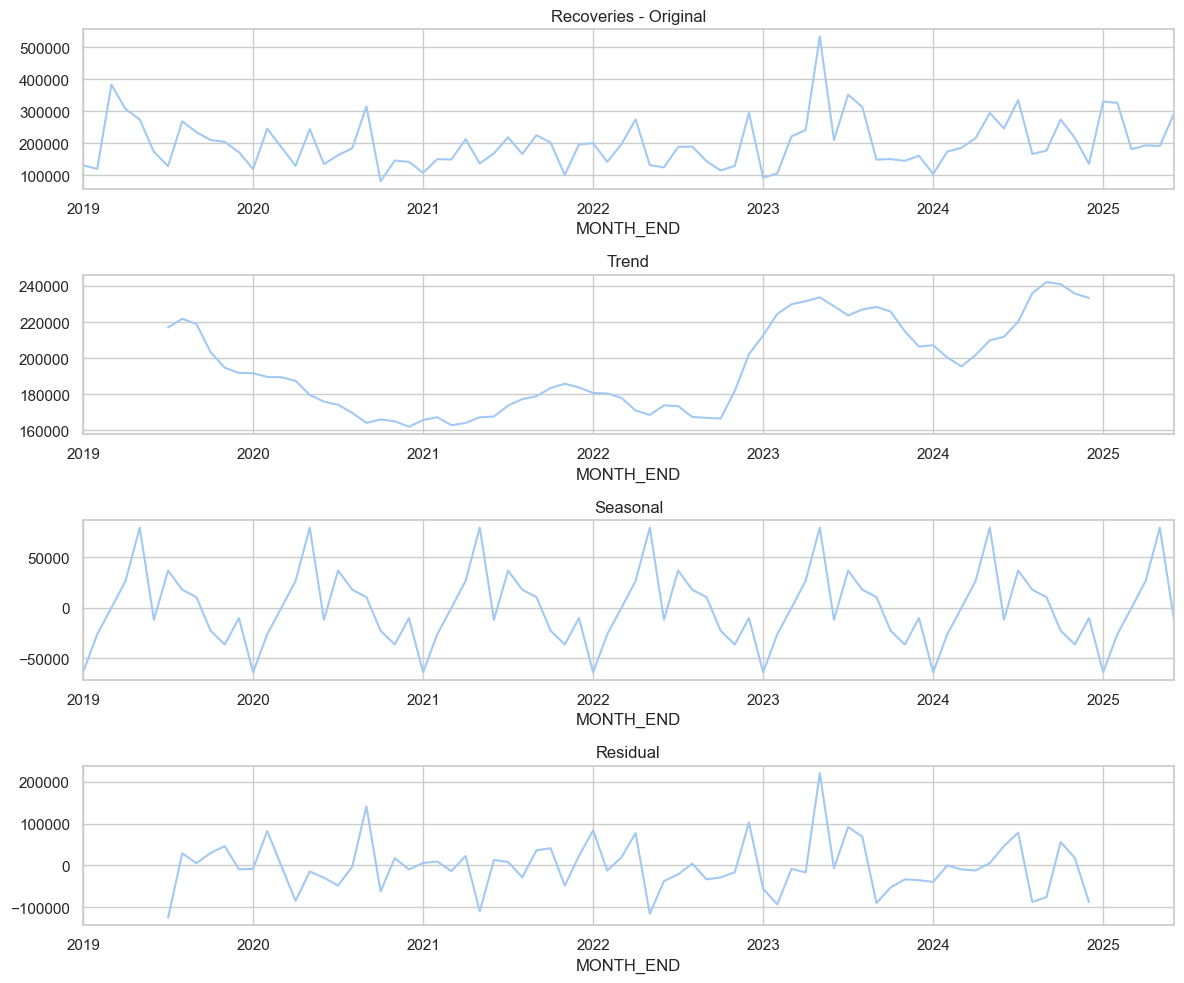

In [ ]:
# Seasonal decomposition
def analyze_seasonality(series, title, period=12):
    """Decompose time series into trend, seasonal, residual"""
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    decomposition.observed.plot(ax=axes[0], title=f'{title} - Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.tight_layout()
    
    # Seasonality strength
    seasonal_strength = np.var(decomposition.seasonal.dropna()) / np.var(decomposition.resid.dropna())
    print(f"{title} Seasonality Strength: {seasonal_strength:.3f}")
    
    return decomposition

# Apply to your data
charge_decomp = analyze_seasonality(core_data['CO_BAL'], 'Charge-offs')
recovery_decomp = analyze_seasonality(core_data['REC_BAL'], 'Recoveries')

##### 1.4 Correlation Analysis and Outlier Detection

Charge-off outliers: 0
Recovery outliers: 1


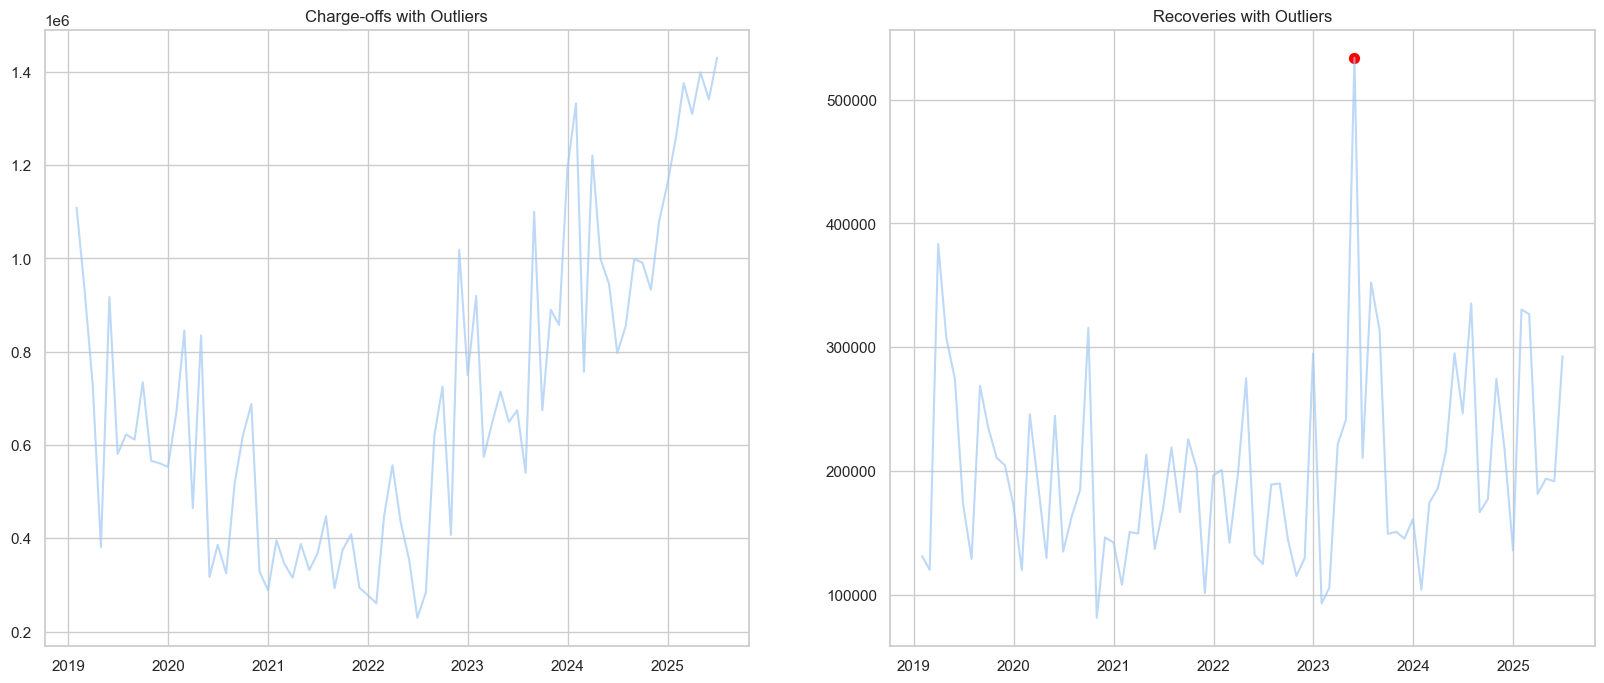

In [11]:
# Outlier detection
def detect_outliers(series, method='iqr', threshold=1.5):
    """Detect outliers using IQR or Z-score method"""
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = series[(series < lower_bound) | (series > upper_bound)]
    else:  # z-score
        z_scores = np.abs((series - series.mean()) / series.std())
        outliers = series[z_scores > threshold]
    
    return outliers

charge_outliers = detect_outliers(core_data['CO_BAL'])
recovery_outliers = detect_outliers(core_data['REC_BAL'])

print(f"Charge-off outliers: {len(charge_outliers)}")
print(f"Recovery outliers: {len(recovery_outliers)}")

# Plot outliers
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].plot(core_data.index, core_data['CO_BAL'], alpha=0.7)
axes[0].scatter(charge_outliers.index, charge_outliers.values, color='red', s=50)
axes[0].set_title('Charge-offs with Outliers')

axes[1].plot(core_data.index, core_data['REC_BAL'], alpha=0.7)
axes[1].scatter(recovery_outliers.index, recovery_outliers.values, color='red', s=50)
axes[1].set_title('Recoveries with Outliers')

plt.show()

In [ ]:
fig = plt.figure(figsize = (10, 10))

#### 2) Plot our Data for Visual Analysis

In [ ]:
min(core_data['CO_BAL'])

229725.86

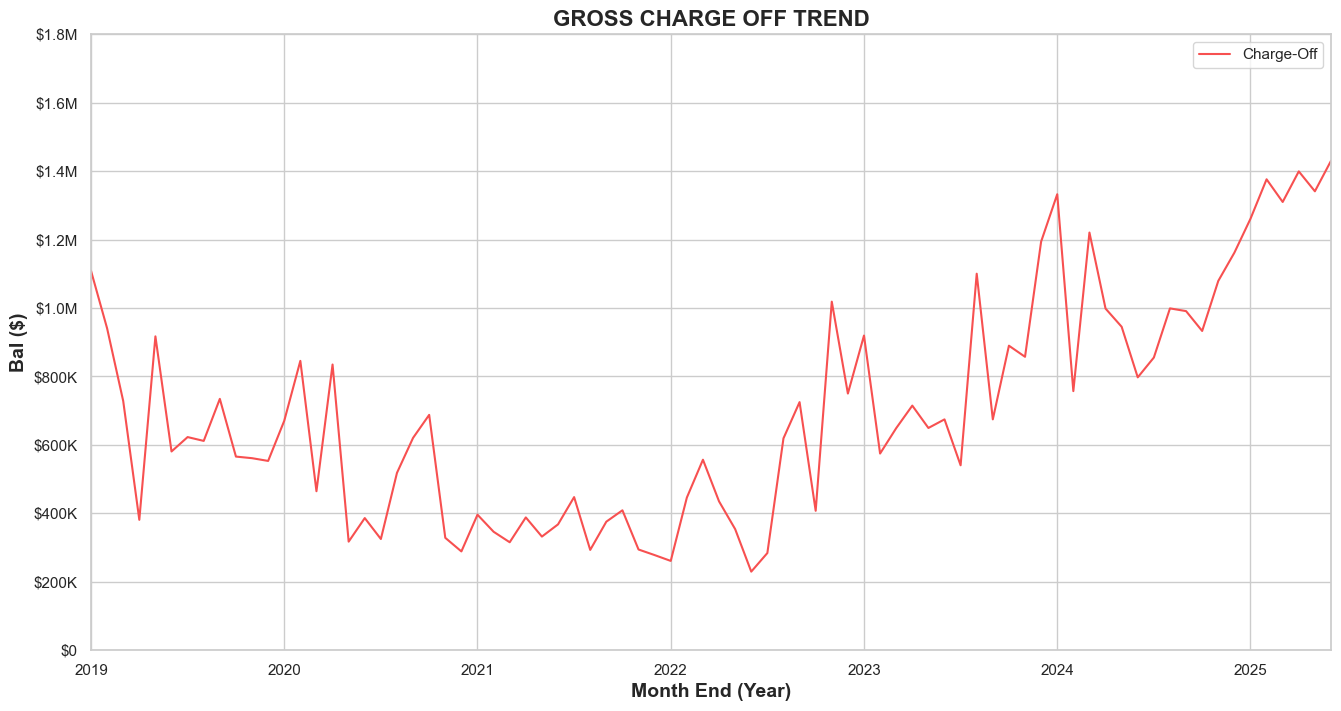

In [ ]:
# Plot Gross Charge-Off Data
ax = core_data['CO_BAL'].plot(figsize=(16,8), color='#f75050')
ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Bal ($)', size=14, fontweight='bold')
ax.set_xlabel('Month End (Year)', size=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M']);
plt.legend(['Charge-Off'], loc=0)
plt.ylim(0, 1800000)
plt.title('GROSS CHARGE OFF TREND', size=16, fontweight = 'bold')
plt.show();

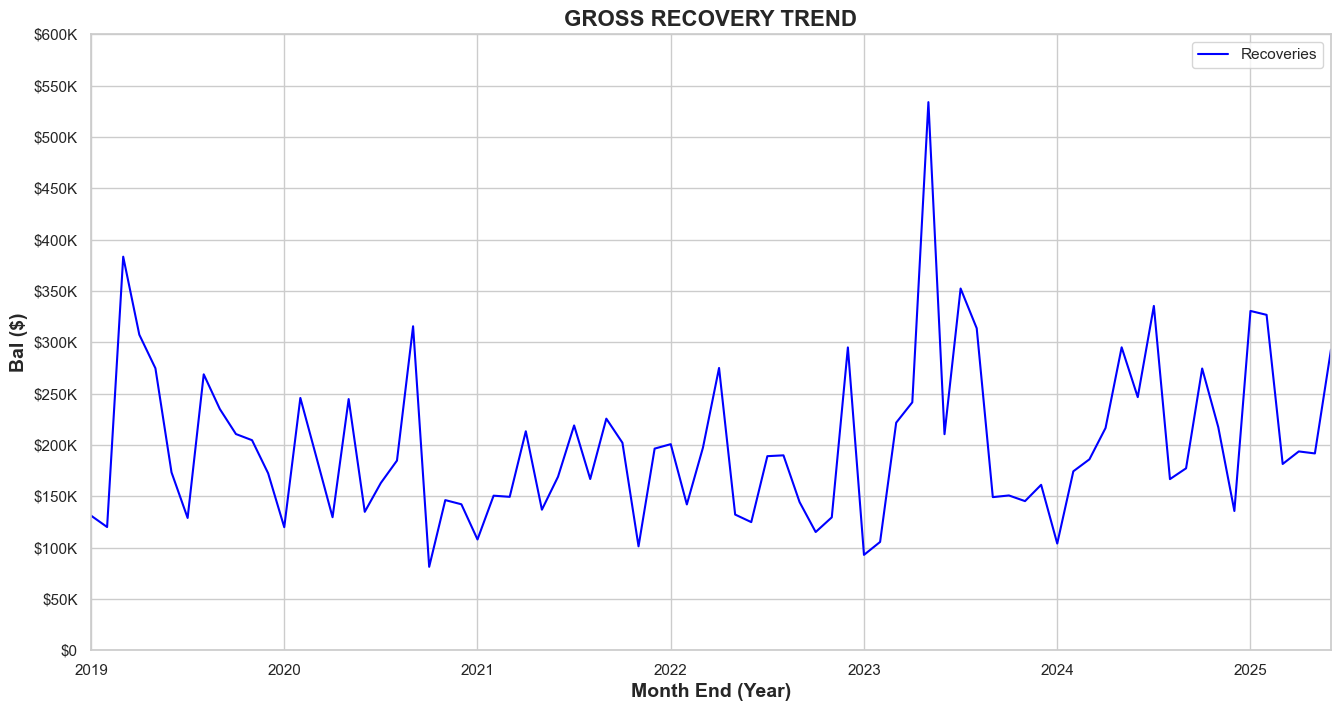

In [ ]:
# Plot Recovery Data
ax = core_data['REC_BAL'].plot(figsize=(16,8), color='blue')
ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Bal ($)', size=14, fontweight='bold')
ax.set_xlabel('Month End (Year)', size=14, fontweight='bold')
ax.set_yticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000], 
              ['$0', '$50K', '$100K', '$150K', '$200K', '$250K', '$300K', '$350K', '$400K', '$450K', '$500K', '$550K', '$600K']);
plt.legend(['Recoveries'], loc=0)
plt.ylim(0, 600000)
plt.title('GROSS RECOVERY TREND', size = 16, fontweight='bold')
plt.show();

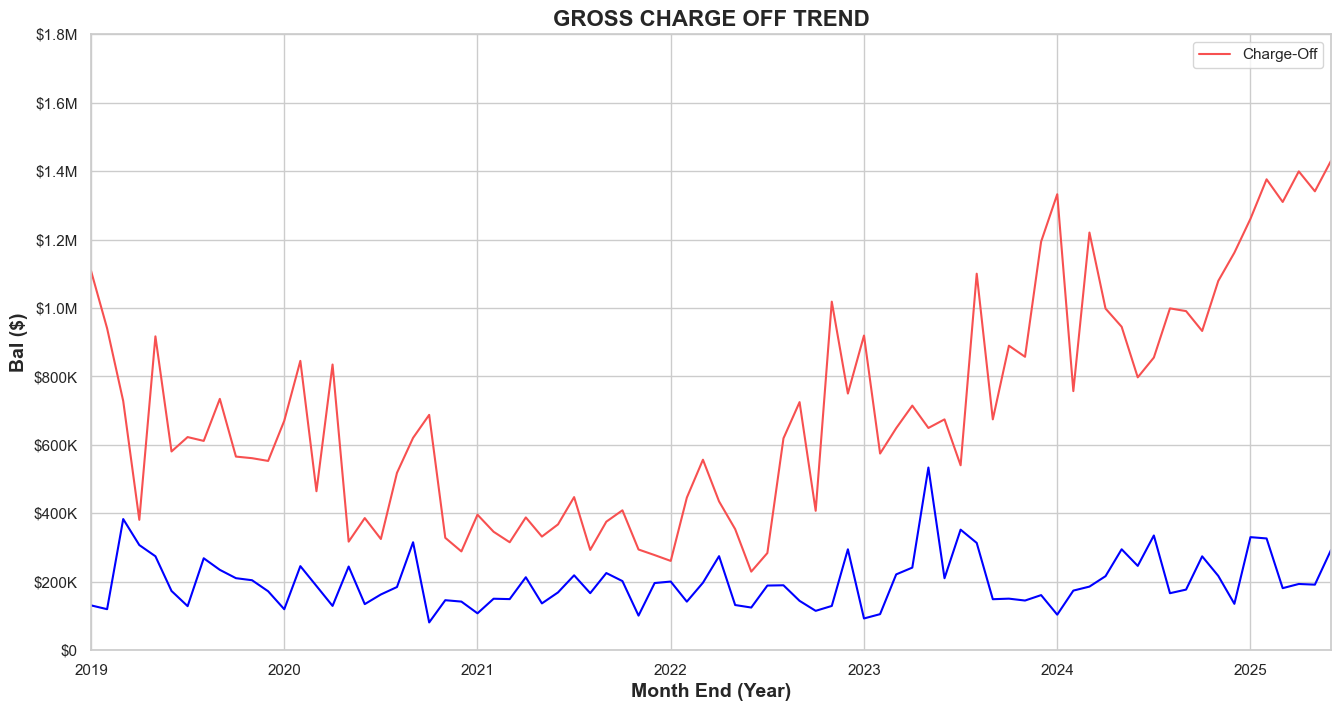

In [ ]:
# Plot Charge-Off and Recovery Data Together
ax = core_data['CO_BAL'].plot(figsize=(16,8), color='#f75050')
ax = core_data['REC_BAL'].plot(figsize=(16,8), color='blue')
ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Bal ($)', size=14, fontweight='bold')
ax.set_xlabel('Month End (Year)', size=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M']);
plt.legend(['Charge-Off'], loc=0)
plt.ylim(0, 1800000)
plt.title('GROSS CHARGE OFF TREND', size=16, fontweight = 'bold')
plt.show();

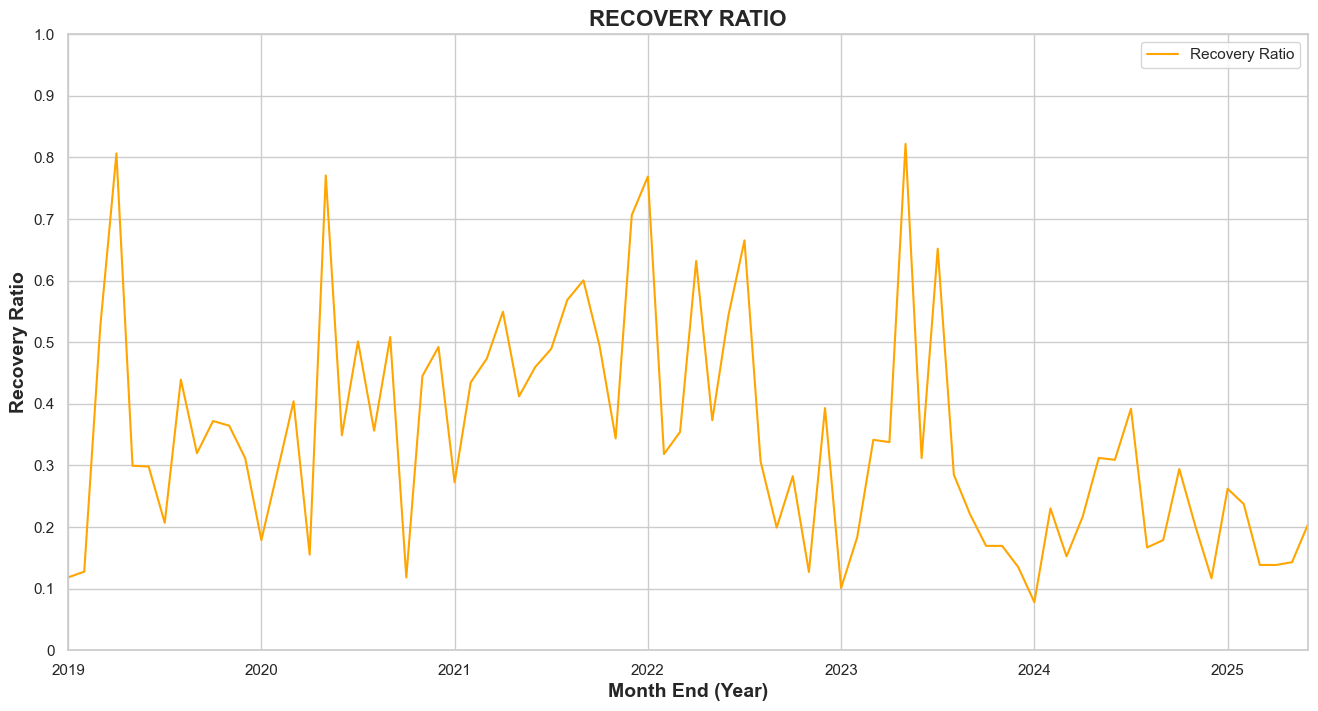

In [ ]:
# Plot Charge-Off and Recovery Data Together
ax = core_data['ratio'].plot(figsize=(16,8), color='orange')
ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Recovery Ratio', size=14, fontweight='bold')
ax.set_xlabel('Month End (Year)', size=14, fontweight='bold')
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
              ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']);
plt.legend(['Recovery Ratio'], loc=0)
plt.ylim(0, 1)
plt.title('RECOVERY RATIO', size=16, fontweight = 'bold')
plt.show();

#### Generate Charge-Off Trend Line

In [ ]:
# Tuple unpacking for charge_offs
co_cycle, co_trend = hpfilter(core_data['CO_BAL'], lamb=1000)

In [ ]:
core_trend_data = core_data

In [ ]:
#create trend feature
core_trend_data['CO_BAL_TREND'] = co_trend

In [ ]:
# Calculate error bands using the cyclical component
cycle_std = co_cycle.std()
trend_upper = co_trend + (cycle_std * 1.96)
trend_lower = co_trend - (cycle_std * 1.96)

In [ ]:
#Plot upper and Lower Bounds on CO_BAL_TREND
co_mean = core_trend_data['CO_BAL_TREND'].mean()
co_std = core_trend_data['CO_BAL_TREND'].std()
core_trend_data['CO_BAL_TREND_upper'] = core_trend_data['CO_BAL_TREND']+(co_std*1.96)
core_trend_data['CO_BAL_TREND_lower'] = core_trend_data['CO_BAL_TREND']-(co_std*1.96)

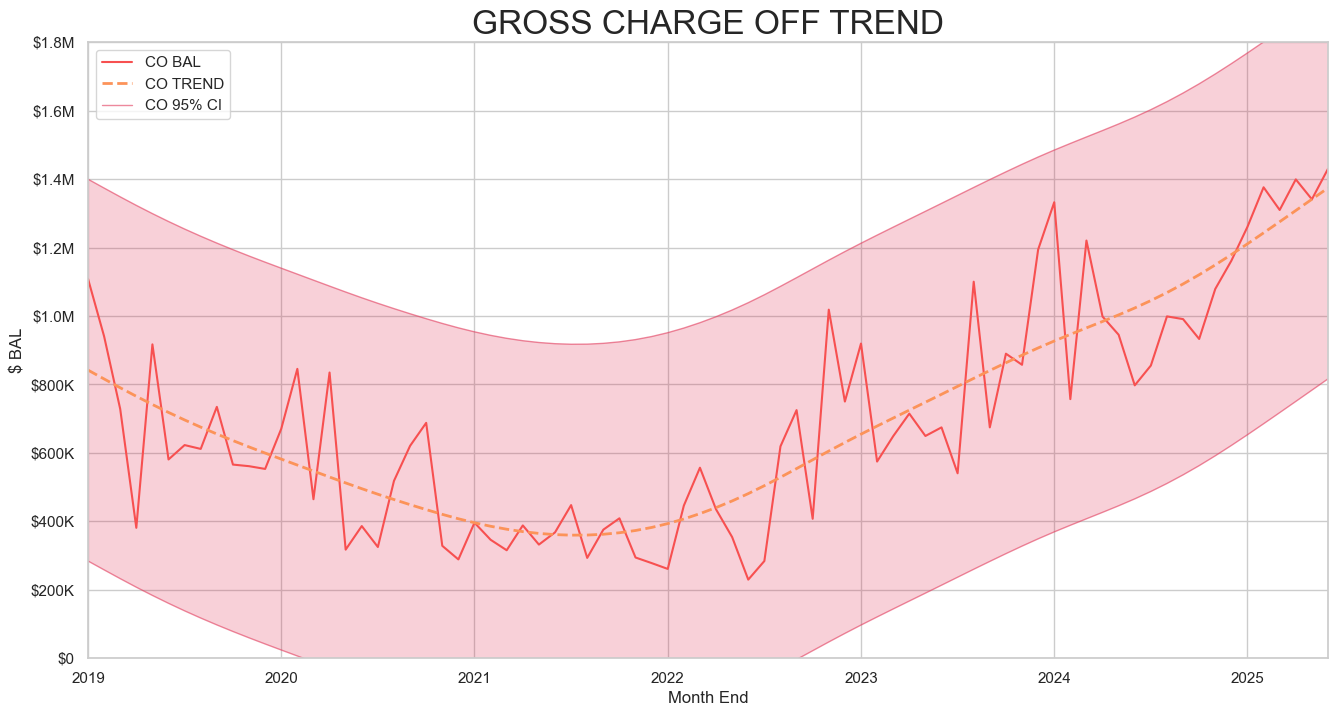

In [ ]:
# Visualize the data

#CO_BAL CHART PRIOR TO FORECASTING

ax = core_trend_data['CO_BAL'].plot(figsize=(16,8), color='#f75050')
ax = core_trend_data['CO_BAL_TREND'].plot(color='#fc9359', linestyle="--", lw=2)
ax = core_trend_data['CO_BAL_TREND_upper'].plot(color='crimson', alpha=0.5, lw=1)
ax = core_trend_data['CO_BAL_TREND_lower'].plot(color='crimson', alpha=0.5, lw=1)
ax.fill_between(core_trend_data.index.values, core_trend_data['CO_BAL_TREND_lower'], core_trend_data['CO_BAL_TREND_upper'], facecolor='crimson', alpha=0.2)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel='$ BAL')
ax.set(xlabel= 'Month End')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M']);
plt.legend(['CO BAL', 'CO TREND', 'CO 95% CI' ], loc=0)
plt.ylim(0, 1800000)
plt.title('GROSS CHARGE OFF TREND', size=24)
plt.show();